In [2]:
import h5py
import io
import matplotlib.pyplot as plt
#%matplotlib nbagg
import numpy as np
#import matplotlib.image as mpimg
from PIL import Image
import urllib
import os
import pandas as pd
import scipy.io
from smartgrid.image_processing.solar_angles_computation import *
import datetime

In [3]:
CMS = pd.read_csv('./SolarForecasting_Matlab_Octo/databases/CMS_EXP_Walon_Donnees_1minute.dat',skiprows=[0,2,3],low_memory=False)

In [4]:
threshold_std = scipy.io.loadmat('./SolarForecasting_Matlab_Octo/databases/threshold_std.mat')['threshold_std']

In [5]:
adnot_data = pd.read_csv('./andot_data.csv')
latitude = np.array([[42.7983]])
longitude = np.array([[2.8856]])
adnot_data.date = adnot_data.date.apply(lambda x : pd.to_datetime(x[:19]))
adnot_data.index = adnot_data.date
adnot_data = pd.DataFrame(adnot_data.resample('1Min').pad())

In [6]:
GHI = CMS[['TIMESTAMP','RG_moy_0_I']]
GHI.TIMESTAMP = pd.to_datetime(GHI.TIMESTAMP)
adnot = pd.merge(left=adnot_data, right=GHI, left_on=adnot_data.index, right_on = 'TIMESTAMP').drop('date',1)

/Users/thomas/anaconda3/envs/rivesaltes/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [7]:
angles = [solar_angles_computation(np.datetime64(timestamp), latitude=latitude, longitude=longitude) for timestamp in adnot.TIMESTAMP]
azimuth = list()
zenith = list()
for element in angles : 
    zenith.append(element[0][0][0])
    azimuth.append(element[1][0][0])
adnot['azimuth'] = azimuth
adnot['zenith'] = zenith

/Users/thomas/Documents/Riversaltes/rivesaltes/smartgrid/image_processing/solar_angles_computation.py:48: RuntimeWarning: invalid value encountered in arccos
  * np.sin(latitude * np.pi / 180) * np.cos(hour_angle)) / np.sin(zenith))


In [8]:
adnot.index = adnot.TIMESTAMP
adnot.drop('TIMESTAMP',1,inplace=True)

In [9]:
adnot['std'] = adnot.groupby(pd.TimeGrouper(freq='15Min', base=30, label='right')).std()['RG_moy_0_I']

/Users/thomas/anaconda3/envs/rivesaltes/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if __name__ == '__main__':


In [10]:
adnot['std']=  adnot['std'].fillna(method='backfill')

In [11]:
adnot.shape

(800084, 5)

## 1er critere

In [12]:
threshold_CI = 0.1
adnot = adnot[adnot.cloud_index_walon_gps > threshold_CI]
adnot.shape

(112924, 5)

## 2eme critere

In [13]:
adnot['Y_model_max'] = adnot.groupby(pd.TimeGrouper(freq='15Min', base=30, label='right')).apply(lambda x : np.polyval(threshold_std[1,:],abs(np.sin(np.deg2rad(x.azimuth.mean())))))
adnot['Y_model_min'] = adnot.groupby(pd.TimeGrouper(freq='15Min', base=30, label='right')).apply(lambda x : np.polyval(threshold_std[0,:],abs(np.sin(np.deg2rad(x.azimuth.mean())))))

/Users/thomas/anaconda3/envs/rivesaltes/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  if __name__ == '__main__':
/Users/thomas/anaconda3/envs/rivesaltes/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  from ipykernel import kernelapp as app


In [14]:
adnot['Y_model_max']=  adnot['Y_model_max'].fillna(method='backfill')
adnot['Y_model_min']=  adnot['Y_model_min'].fillna(method='backfill')

In [15]:
adnot = adnot[(adnot['std']<adnot.Y_model_max) & (adnot['std']>adnot.Y_model_min)]

In [16]:
adnot.shape

(62208, 7)

## 3eme critere

In [17]:
adnot['date'] = adnot.index

In [18]:
adnot['shift'] =  adnot.date.shift(-60) - adnot.date 

In [19]:
adnot_final = adnot[adnot['shift'] <= datetime.timedelta(hours=1)]

In [20]:
adnot_final = adnot_final.replace([np.inf, -np.inf], np.nan).dropna()

In [21]:
adnot_final['date'] = adnot_final.date.dt.dayofyear

In [22]:
adnot_final.date = adnot_final.date.astype('float')

In [23]:
adnot_final = adnot_final[~adnot_final.index.duplicated(keep='first')]

## Calcul des paramètres pour adnot

In [24]:
from scipy.optimize import curve_fit

In [25]:
def compute_GHI(df,p1,p2,p3,p4,p5,p6) : 
    doy = np.array(df.date)
    zenith = np.array(df.zenith)
    return (p1 * np.cos(np.deg2rad(360 / 365.25 * doy + p2)) + p3) * np.cos(np.deg2rad(zenith)) ** (p4 * np.cos(np.deg2rad(360 / 365.25 * doy + p5)) + p6)

In [26]:
y = np.array(adnot_final[(adnot_final.date==145) | (adnot_final.date==289)].RG_moy_0_I)
x = adnot_final[(adnot_final.date==145) | (adnot_final.date==289)]
popt, pcov =curve_fit(f=compute_GHI,xdata=x,ydata=y,bounds=[-2,[100, -1.0, 1500, 0.1, 100, 2]])

In [27]:
popt

array([ 8.20630791e+01, -1.13556174e+00,  1.15810318e+03,  1.56397451e-02,
        1.07080192e+01,  1.20840451e+00])

In [28]:
popt_old = scipy.io.loadmat('./SolarForecasting_Matlab_Octo/databases/pAdnotClearskyModel.mat')['pAdnotClearskyModel']

In [29]:
popt_old

array([[ 9.75054081e+01],
       [-1.12991172e+01],
       [ 1.12783268e+03],
       [ 6.15340187e-03],
       [ 3.42894626e+01],
       [ 1.18527654e+00]])

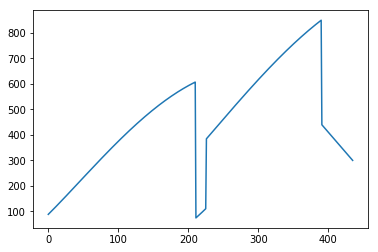

In [30]:
plt.plot(compute_GHI(x, *popt))

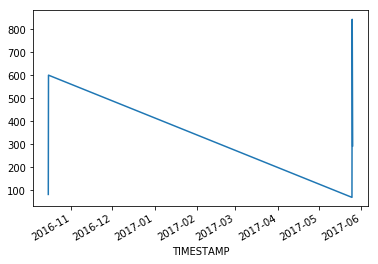

In [31]:
adnot_final[(adnot_final.date==145) | (adnot_final.date==289)].RG_moy_0_I.plot()

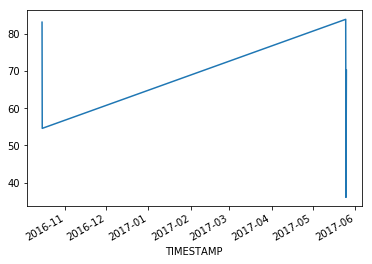

In [32]:
adnot_final[(adnot_final.date==145) | (adnot_final.date==289)].zenith.plot()

In [33]:
p1 = popt[0]
p2 = popt[1]
p3 = popt[2]
p4 = popt[3]
p5 = popt[4]
p6 = popt[5]

doy = adnot_final.date[0]
zenith = adnot_final.zenith[0]
(p1 * np.cos(np.deg2rad(360 / 365.25 * doy + p2)) + p3) * np.cos(np.deg2rad(zenith)) ** (p4 * np.cos(np.deg2rad(360 / 365.25 * doy + p5)) + p6)

74.25805478146279

In [34]:
p1 = popt_old[0]
p2 = popt_old[1]
p3 = popt_old[2]
p4 = popt_old[3]
p5 = popt_old[4]
p6 = popt_old[5]

doy = adnot_final.date[0]
zenith = adnot_final.zenith[0]
(p1 * np.cos(np.deg2rad(360 / 365.25 * doy + p2)) + p3) * np.cos(np.deg2rad(zenith)) ** (p4 * np.cos(np.deg2rad(360 / 365.25 * doy + p5)) + p6)

array([75.29435968])